In [1]:
# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
from scipy import interpolate
import scipy as sp
from scipy.optimize import curve_fit
import datetime

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn as sn
import random

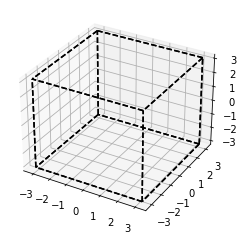

In [31]:
# parameters
n_max = 3 # how many points in k-space to investigate from the origin 
n_zones = 1 # how many zones to plot
make_plot = True
eps_roundoff = 1e-10 # round-off error margin


# define the lattice vectors in real space
xhat = np.array([1,0,0])
yhat = np.array([0,1,0])
zhat = np.array([0,0,1])

# simple cubic
a1 = xhat
a2 = yhat
a3 = zhat

# face-centered cubic
# a1 = 0.5*(yhat + zhat)
# a2 = 0.5*(zhat + xhat)
# a3 = 0.5*(xhat + yhat)

# body-centered cubic
# a1 = 0.5*(-xhat + yhat + zhat)
# a2 = 0.5*(xhat - yhat + zhat)
# a3 = 0.5*(xhat + yhat - zhat)

# calculate the reciprocal vectors

trip_prod = np.dot(a1,np.cross(a2,a3))

b1 = (2*np.pi/trip_prod)*np.cross(a2,a3)
b2 = (2*np.pi/trip_prod)*np.cross(a3,a1)
b3 = (2*np.pi/trip_prod)*np.cross(a1,a2)

# calculate K-points in the reciprocal lattice

# initialize list of "quantum numbers"
n1s = []
n2s = []
n3s = []
Ks = []

# loop over indices to populate "quantum numbers" and K-vectors
for n1 in range(-n_max,n_max,1):
    for n2 in range(-n_max,n_max,1):
        for n3 in range(-n_max,n_max,1):
            n1s.append(n1)
            n2s.append(n2)
            n3s.append(n3)
            Ks.append(n1*b1 + n2*b2 + n3*b3)
            
K_DF = pd.DataFrame({'K':Ks,
                     'n1':n1s,
                     'n2':n2s,
                     'n3':n3s
                    })

# assign "distances" from the origin
K_DF['n^2'] = K_DF['n1']**2 + K_DF['n2']**2 + K_DF['n3']**2
# sort the entries according to distance
K_DF = K_DF.sort_values('n^2',ignore_index=True)

# rank the planes by distance
ranks = []
rank = 0
for ii in range(len(K_DF['n^2'].values)):
    if ii == 0:
        ranks.append(rank)
        continue
    elif K_DF['n^2'].values[ii] != K_DF['n^2'].values[ii-1]:
        rank += 1
    ranks.append(rank)
K_DF['Distance Index'] = ranks

# we set them all up
# this is the exciting bit
# now loop over zones
for zonem1 in range(n_zones):
    zone = zonem1 + 1
    
    # planes on zone edges
    # these ones are important, and
    # the others ignored
    
    # zone 1 is unique
    # there is no plane set below
    # just take the high ones
    if zone == 1:
        K_red = K_DF[K_DF['Distance Index'] == zone]
    else:
        # look above - high K points
        # take these from the master sheet
        # reject the others
        K_hi = K_DF[K_DF['Distance Index'] == zone]
        # do it over again
        # but now in opposite world
        # the low points are high
        K_lo = K_DF[K_DF['Distance Index'] == zonem1]
        
        K_red = pd.concat([K_lo,K_hi],ignore_index=True)
        
    # now determine which pairs of planes intersect
#     p_int_idxs = [] # initialize pair list
    line_params = []
    
    # set up list of faces that define the first Brillouin zone
    BZ1_faces = []
    
    if make_plot:
        z_fig = plt.figure()
        ax = z_fig.add_subplot(projection='3d')
    
    # scan over each K-point, corresponding to a face in the cell
    idx_list = list(K_red.index)
    for ii in idx_list:
        
        face = {} # initialize an empty dictionary
        face['K'] = K_red['K'][ii] # assign the corresponding K point
        bounding_lines = [] # initialize a list of parameters to find the lines bounding that face
        edges = [] # initialize a list of vector pairs to describe edges
        
        # generate a list of indices of all other planes
        red_idx_list = [item for item in idx_list if item != ii]
        
        # scan over all other K-planes of equivalent distance to find which ones intersect and if so,
        # define the line of their intersection
        for jj in red_idx_list:
            
            # if the planes are not parallel:
            if np.linalg.norm(np.cross(K_red['K'][ii],K_red['K'][jj])) != 0:
                
#                 p_int_idxs.append([ii,jj])
                
                # find the corresponding line of intersection between the planes
                K1 = K_red['K'][ii] # K-point 1
                K2 = K_red['K'][jj] # K-point 2
                v = np.cross(K1,K2) # "velocity" vector lying along the line
                
                # any point on the line will do, but for simplicity we choose the point closest to the origin,
                # so p (dot) v = 0. We can set up a matrix of coefficients and solve by inverting:
                K_mat = np.array([K1,K2,v])
                b = np.array([0.5*np.dot(K1,K1),0.5*np.dot(K2,K2),0])
                p = np.matmul(np.linalg.inv(K_mat),b)
                
                line_params.append([p,v])
                bounding_lines.append([p,v])
        
        # now scan over all bounding lines
        for kk, params in enumerate(bounding_lines):
            
            edge = [] # initialize the pair of endpoints defining an edge
            
            # generate a list of all the other lines
            red_lines = bounding_lines.copy()
            red_lines.pop(kk)
            
            # for each other line in the face:
            for params2 in red_lines:
                # extract parameters corresponding to the two lines
                p1 = params[0]
                v1 = params[1]
                p2 = params2[0]
                v2 = params2[1]
                
                # reject parallel line pairs
                if np.linalg.norm(np.cross(v1,v2)) == 0:
                    continue
                    
                # solve for the parameters (t-values) yielding the minimum distance between lines
                V_mat = np.array([[np.dot(v1,v1), -np.dot(v1,v2)],
                                  [-np.dot(v1,v2), np.dot(v2,v2)],
                                 ])
                q = np.array([-np.dot(v1,p1-p2),np.dot(v2,p1-p2)])
                t = np.matmul(np.linalg.inv(V_mat),q)
                # calculate the displacement vector between them
                line_disp = p1 - p2 + t[0]*v1 - t[1]*v2

                # if the lines intersect, one of the endpoints has been found:
                if np.linalg.norm(line_disp) < eps_roundoff:
                    edge.append(p1 + t[0]*v1)
                    
            edges.append(edge) # after looking at all other bounding lines, keep track of the edges
            
            if make_plot:
                t = np.linspace(0,1,num=2)

                x = edge[0][0] + t*(edge[1][0] - edge[0][0])
                y = edge[0][1] + t*(edge[1][1] - edge[0][1])
                z = edge[0][2] + t*(edge[1][2] - edge[0][2])

                ax.plot(x,y,z,'k--')
        
        face['Edges'] = edges # after looking at all bounding lines, add the set of edges to the face dictionary
        BZ1_faces.append(face)
    
                
                
#     # now identify vertices
#     verts = []
#     for ii in range(len(line_params)):
#         for jj in range(ii):
#             # extract parameters corresponding to the two lines
#             p1 = line_params[ii][0]
#             v1 = line_params[ii][1]
#             p2 = line_params[jj][0]
#             v2 = line_params[jj][1]
            
#             # reject parallel line pairs
#             if np.linalg.norm(np.cross(v1,v2)) == 0:
#                 continue
            
#             # solve for the parameters (t-values) yielding the minimum distance between lines
#             V_mat = np.array([[np.dot(v1,v1), -np.dot(v1,v2)],
#                               [-np.dot(v1,v2), np.dot(v2,v2)],
#                              ])
#             q = np.array([-np.dot(v1,p1-p2),np.dot(v2,p1-p2)])
#             t = np.matmul(np.linalg.inv(V_mat),q)
#             # calculate the displacement
#             line_disp = p1 - p2 + t[0]*v1 - t[1]*v2
            
#             # if the lines intersect:
#             if np.sum(line_disp) == 0:
#                 # check that the vertex hasn't already been added
#                 match = False
#                 for vert in verts:
#                     if np.linalg.norm(p1 + t[0]*v1 - vert) < eps_roundoff:
#                         match = True
#                         break
#                 # and a duplicate is not found, add the vertex to the list
#                 if not match:
#                     verts.append(p1 + t[0]*v1)
        
    
#     if make_plot:
#         z_fig = plt.figure()
#         ax = z_fig.add_subplot(projection='3d')

#         t = np.linspace(-0.1,0.1,num=501)
#         for params in line_params:
#             p = params[0]
#             v = params[1]

#             x = p[0] + t*v[0]
#             y = p[1] + t*v[1]
#             z = p[2] + t*v[2]

#             ax.plot(x,y,z,'k--')
            
    # now that we 
        
                
    
            

In [28]:
BZ1_faces

[{'K': array([-6.28318531,  6.28318531,  6.28318531]),
  'Edges': [[array([-8.88178420e-16,  0.00000000e+00,  9.42477796e+00]),
    array([-9.42477796e+00,  0.00000000e+00,  8.88178420e-16])],
   [array([0.        , 0.        , 9.42477796]),
    array([9.42477796, 9.42477796, 9.42477796])],
   [array([-9.42477796e+00,  8.88178420e-16,  0.00000000e+00]),
    array([-8.88178420e-16,  9.42477796e+00,  0.00000000e+00])],
   [array([9.42477796, 9.42477796, 9.42477796]),
    array([0.        , 9.42477796, 0.        ])]]},
 {'K': array([-6.28318531, -6.28318531,  6.28318531]),
  'Edges': [[array([-8.88178420e-16,  0.00000000e+00,  9.42477796e+00]),
    array([-9.42477796e+00,  0.00000000e+00,  8.88178420e-16])],
   [array([ 0.00000000e+00, -8.88178420e-16,  9.42477796e+00]),
    array([ 0.00000000e+00, -9.42477796e+00,  8.88178420e-16])],
   [array([-9.42477796,  0.        ,  0.        ]),
    array([-9.42477796, -9.42477796, -9.42477796])],
   [array([ 0.        , -9.42477796,  0.        ]),

In [21]:
for kk, params in enumerate(bounding_lines):
            
    edge = [] # initialize the pair of endpoints defining an edge

    # generate a list of all the other lines
    red_lines = bounding_lines.copy()
    red_lines.pop(kk)

    # for each other line in the face:
    for params2 in red_lines:
        # extract parameters corresponding to the two lines
        p1 = params[0]
        v1 = params[1]
        p2 = params2[0]
        v2 = params2[1]

        # reject parallel line pairs
        if np.linalg.norm(np.cross(v1,v2)) == 0:
            continue

        # solve for the parameters (t-values) yielding the minimum distance between lines
        V_mat = np.array([[np.dot(v1,v1), -np.dot(v1,v2)],
                          [-np.dot(v1,v2), np.dot(v2,v2)],
                         ])
        q = np.array([-np.dot(v1,p1-p2),np.dot(v2,p1-p2)])
        t = np.matmul(np.linalg.inv(V_mat),q)
        # calculate the displacement vector between them
        line_disp = p1 - p2 + t[0]*v1 - t[1]*v2

        # if the lines intersect, one of the endpoints has been found:
        if np.linalg.norm(line_disp) < eps_roundoff:
            edge.append(p1 + t[0]*v1)

    edges.append(edge) # after looking at all other bounding lines, keep track of the edges

In [24]:
params = bounding_lines[0]
red_lines = bounding_lines.copy()
red_lines.pop(0)